In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from datetime import datetime as dt
import streamlit as st
from streamlit_keplergl import keplergl_static
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_parquet("2022_Citibike_Dataset.parquet", engine = "pyarrow")

In [3]:
data

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,source,avgTempCelsius
0,BFD29218AB271154,electric_bike,2022-01-21 13:13:43.392,2022-01-21 13:22:31.463,West End Ave & W 107 St,7650.05,Mt Morris Park W & W 120 St,7685.14,40.802117,-73.968181,40.804038,-73.945925,member,202201-citibike-tripdata_1,-6.0
1,7C953F2FD7BE1302,classic_bike,2022-01-10 11:30:54.162,2022-01-10 11:41:43.422,4 Ave & 3 St,4028.04,Boerum Pl\t& Pacific St,4488.09,40.673746,-73.985649,40.688489,-73.991160,member,202201-citibike-tripdata_1,1.6
2,95893ABD40CED4B8,electric_bike,2022-01-26 10:52:43.096,2022-01-26 11:06:35.227,1 Ave & E 62 St,6753.08,5 Ave & E 29 St,6248.06,40.761227,-73.960940,40.745168,-73.986831,member,202201-citibike-tripdata_1,-2.3
3,F853B50772137378,classic_bike,2022-01-03 08:35:48.247,2022-01-03 09:10:50.475,2 Ave & E 96 St,7338.02,5 Ave & E 29 St,6248.06,40.783964,-73.947167,40.745168,-73.986831,member,202201-citibike-tripdata_1,1.4
4,7590ADF834797B4B,classic_bike,2022-01-22 14:14:23.043,2022-01-22 14:34:57.474,6 Ave & W 34 St,6364.10,5 Ave & E 29 St,6248.06,40.749640,-73.988050,40.745168,-73.986831,member,202201-citibike-tripdata_1,-5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838801,1F223EDAFF420AE3,electric_bike,2022-12-01 20:26:45.847,2022-12-01 20:30:46.012,Avenue D & E 3 St,5436.09,Stanton St & Chrystie St,5523.02,40.720701,-73.977939,40.722293,-73.991475,member,202212-citibike-tripdata_2,5.7
29838802,CFA5C560ACB73B8E,classic_bike,2022-12-26 13:46:34.237,2022-12-26 13:52:43.900,43 Ave & 47 St,6209.05,39 Ave & 45 St,6401.03,40.744806,-73.917290,40.749478,-73.918265,member,202212-citibike-tripdata_2,-4.7
29838803,11C8C5E0DB947B07,classic_bike,2022-12-01 05:56:14.903,2022-12-01 06:06:10.357,Avenue D & E 3 St,5436.09,Bleecker St & Crosby St,5679.08,40.720828,-73.977932,40.726156,-73.995102,member,202212-citibike-tripdata_2,5.7
29838804,5B9B083C534A5964,classic_bike,2022-12-02 11:54:15.871,2022-12-02 12:01:00.747,Montague St & Clinton St,4677.06,Sands St & Jay St,4821.03,40.694271,-73.992327,40.700119,-73.986200,member,202212-citibike-tripdata_2,3.4


In [6]:
test = data.sample(frac = 0.01, random_state = 123)

## Executive Summary & KPIs

In [4]:
summary_data_2022 = pd.read_csv(r"Data\2022_summary_df.csv")
summary_data_2021 = pd.read_csv(r"Data\2021_summary_df.csv")

In [12]:
data = pd.concat([summary_data_2022, summary_data_2021])
data

,rental_count,average_duration,member_perc,bike_type_perc,year
0,29798394,15.485299,0.779798,0.393368,2022
0,27104739,16.409179,0.732531,0.318306,2021


In [43]:
KPI_df = (data
 .melt(id_vars = "year", var_name = "metric", value_name = "value") # unpivot to long format
 .pivot(index = "metric", columns = "year", values = "value") # repivot for side by side
 .rename_axis(columns = None)
 .assign(
     value = lambda df: df[2022],
     delta = lambda df: df.apply(lambda row: (row[2022] - row[2021]) / row[2021]
                                 if row.name in ["rental_count", "average_duration"]
                                 else row[2022] - row[2021],
                                 axis = 1),
 )
 .reset_index()[["metric", "value", "delta"]]
 .set_index("metric")
)

KPI_df

,value,delta
metric,,
average_duration,1.548530e+01,-0.056303
bike_type_perc,3.933680e-01,0.075062
member_perc,7.797977e-01,0.047267
rental_count,2.979839e+07,0.099379


In [45]:
KPI_df.to_csv(r"Data/KPI_df.csv", index = True)

In [47]:
KPI_df = pd.read_csv(r"Data/KPI_df.csv", index_col = "metric")

In [49]:
KPI_df

,value,delta
metric,,
average_duration,1.548530e+01,-0.056303
bike_type_perc,3.933680e-01,0.075062
member_perc,7.797977e-01,0.047267
rental_count,2.979839e+07,0.099379


In [55]:
# read KPI_df
total_rentals = KPI_df.loc["rental_count", "value"]
total_rentals_delta = KPI_df.loc["rental_count","delta"]

avg_duration = KPI_df.loc["average_duration", "value"]
avg_duration_delta = KPI_df.loc["average_duration", "delta"]

member_perc = KPI_df.loc["member_perc", "value"] * 100
member_delta = KPI_df.loc["member_perc","delta"] * 100

ebike_perc = KPI_df.loc["bike_type_perc", "value"] * 100
ebike_delta = KPI_df.loc["bike_type_perc", "delta"] * 100

In [ ]:
col1, col2, col3, col4 = st.columns(4)

with col1:
    st.metric("Total Rides (YTD)", f"{total_rentals:,.0f}", 
              f"{total_rentals_delta * 100:+.1f}% vs LY")

with col2:
    st.metric("Avg Trip Duration", f"{avg_duration:.1f} min", 
              f"{avg_duration_delta * 100:+.1f}% vs LY")

with col3:
    st.metric("Members %", f"{member_perc:.0f}%", 
              f"{member_delta:+.1f}% vs LY")

with col4:
    st.metric("Electric Bike %", f"{ebike_perc:.0f}%", 
              f"{ebike_delta:.0f}% vs LY")

## Seasonality & Demand Patterns

### Day of Week

In [277]:
# Day of Week
dow_df = \
(test
 .groupby(test["started_at"].dt.day_name())
 .size()
 .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
 .to_frame(name = "rental_count")
 .rename_axis("day")
 .reset_index()
)

dow_df

,day,rental_count
0,Monday,39214
1,Tuesday,43383
2,Wednesday,45843
3,Thursday,45776
4,Friday,44493
5,Saturday,42546
6,Sunday,37133


In [279]:
dow_df.to_csv("Data/dow_df.csv", index = False)

In [281]:
dow_df = pd.read_csv(r"Data\dow_df.csv")

In [283]:
dow_df

,day,rental_count
0,Monday,39214
1,Tuesday,43383
2,Wednesday,45843
3,Thursday,45776
4,Friday,44493
5,Saturday,42546
6,Sunday,37133


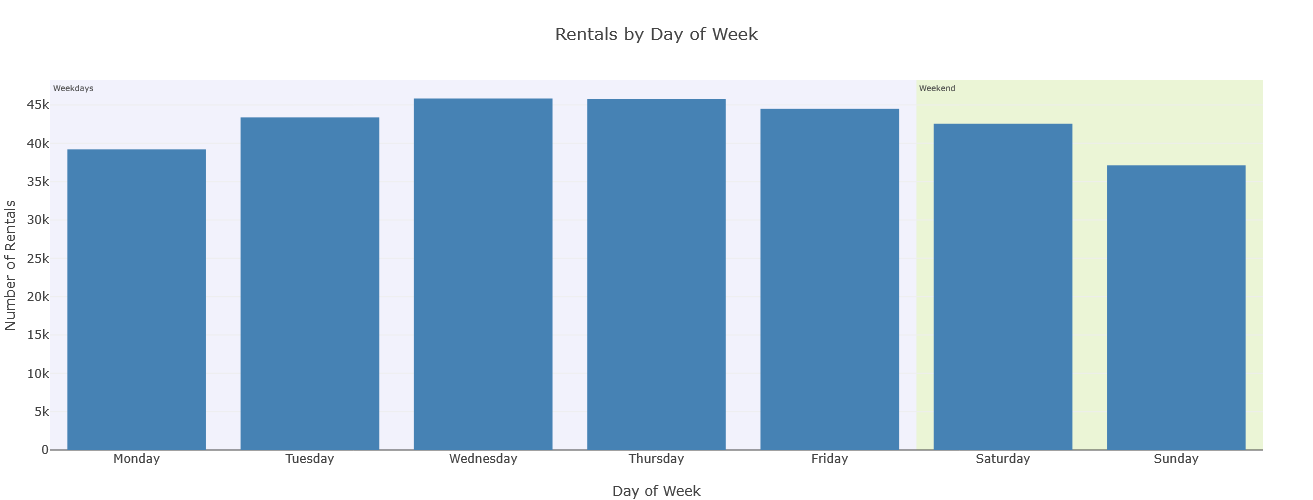

In [285]:
fig = px.bar(
    x = dow_df["day"],
    y = dow_df["rental_count"],
    labels = {"x":"Day of Week", "y":"Number of Rentals"},
    title = "Rentals by Day of Week",
    color_discrete_sequence = ["steelblue"]
)

# highlight weekeday
fig.add_vrect(
    x0 = -0.5, x1 = 4.5,
    fillcolor = "lavender", opacity = 0.5,
    layer = "below", line_width = 0,
    annotation_text = "Weekdays", annotation_position = "top left", annotation_font_size = 8
)

# highlight weekend
fig.add_vrect(
    x0 = 4.5, x1 = 6.5,
    fillcolor = "yellowgreen", opacity = 0.2,
    layer = "below", line_width = 0,
    annotation_text = "Weekend", annotation_position = "top left", annotation_font_size = 8
)

fig.update_layout(
    width = 900, height = 500,
    margin = dict(l = 50, r = 50, t = 80, b = 50)
)

fig.show()

In [148]:
# Extract date and day of week
test["date"] = test["started_at"].dt.date
test["dayofweek"] = test["started_at"].dt.dayofweek  # Mon = 0, Sun = 6

# Count rentals per day
daily_counts = test.groupby("date")["ride_id"].count().reset_index(name="trips")

# Tag weekday vs weekend
daily_counts["is_weekend"] = daily_counts["date"].apply(
    lambda x: pd.Timestamp(x).dayofweek >= 5
)

weekday_trips = daily_counts[daily_counts["is_weekend"] == False]["trips"]
weekend_trips = daily_counts[daily_counts["is_weekend"] == True]["trips"]

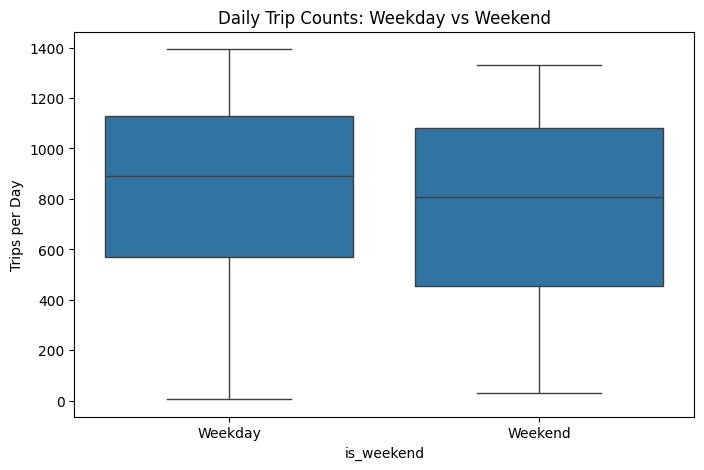

In [150]:
plt.figure(figsize=(8,5))
sns.boxplot(x=daily_counts["is_weekend"], y=daily_counts["trips"])
plt.xticks([0,1], ["Weekday", "Weekend"])
plt.title("Daily Trip Counts: Weekday vs Weekend")
plt.ylabel("Trips per Day")
plt.show()

In [152]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(weekend_trips, weekday_trips, equal_var=False, alternative="greater")

print("t-statistic:", t_stat)
print("p-value:", p_val)

t-statistic: -1.9453822129311578
p-value: 0.9733267106165023


In [154]:
t_stat, p_val = ttest_ind(weekend_trips, weekday_trips, equal_var=False, alternative="less")
print("t-statistic:", t_stat)
print("p-value:", p_val)

t-statistic: -1.9453822129311578
p-value: 0.02667328938349765


### Hour

In [289]:
hourly_df = \
(test
 .assign(hour = test["started_at"].dt.hour)
 .groupby(["hour", "member_casual"])["ride_id"].count().reset_index(name = "trips")
)

hourly_df

,hour,member_casual,trips
0,0,casual,1281
1,0,member,2856
2,1,casual,857
3,1,member,1775
4,2,casual,530
5,2,member,1145
6,3,casual,333
7,3,member,749
8,4,casual,256
9,4,member,691


In [291]:
hourly_df.to_csv("Data/hourly_df.csv", index = False)

In [293]:
hourly_df = pd.read_csv(r"Data\hourly_df.csv")

In [295]:
hourly_df

,hour,member_casual,trips
0,0,casual,1281
1,0,member,2856
2,1,casual,857
3,1,member,1775
4,2,casual,530
5,2,member,1145
6,3,casual,333
7,3,member,749
8,4,casual,256
9,4,member,691


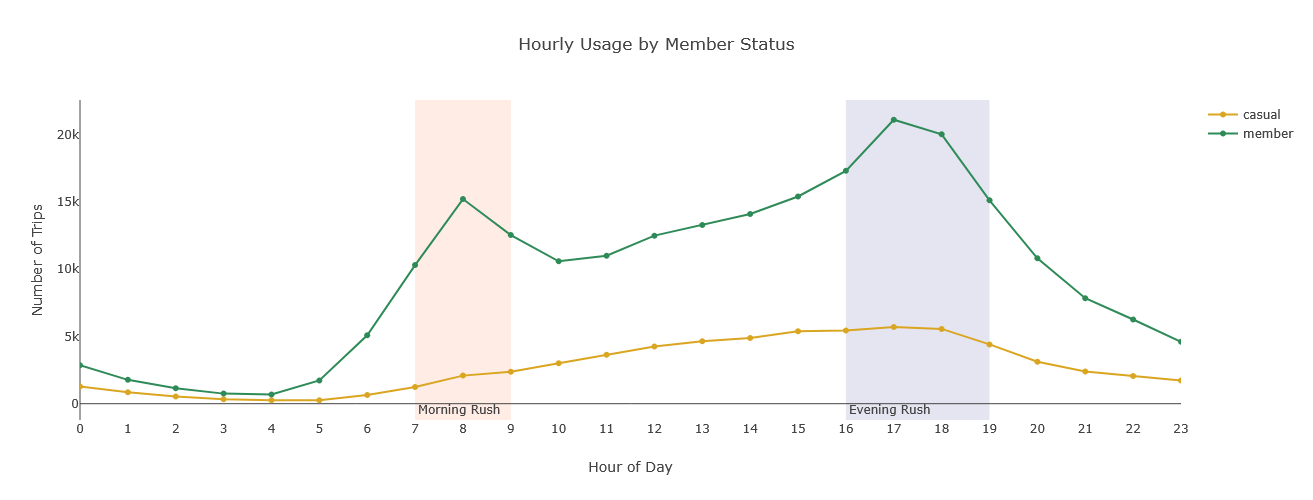

In [297]:
fig = px.line(
    hourly_df,
    x = "hour", y = "trips", color = "member_casual",
    markers = True,
    title = "Hourly Usage by Member Status",
    labels = {"hour": "Hour of Day", "trips": "Number of Trips", "member_casual": ""},
    color_discrete_map = {
        "member": "seagreen",   
        "casual": "goldenrod"     
    }
)

fig.add_vrect(
    x0 = 7, x1 = 9, 
    fillcolor = "orangered", opacity = 0.1, 
    layer = "below", 
    line_width = 0, 
    annotation_text = "Morning Rush", annotation_position = "bottom left"
)

fig.add_vrect(
    x0 = 16, x1 = 19, 
    fillcolor = "navy", opacity = 0.1, 
    layer = "below", 
    line_width = 0, 
    annotation_text = "Evening Rush", annotation_position = "bottom left"
)

fig.update_layout(
    xaxis = dict(dtick = 1, range = [0,23], showgrid = False),
    yaxis = dict(showgrid = False),
    plot_bgcolor = "white",
    width = 900,
    height = 500
)
fig.show()

### Seasonality

In [ ]:
st.markdown("#### Citi Bike Analysis")

fig_2 = make_subplots(specs = [[{"secondary_y": True}]])

# rental count Line
fig_2.add_trace(
    go.Scatter(
        x = rentals_df["date"],
        y = rentals_df["trip_count_7davg"],
        name = "Rentals",
        line = dict(color = "darkcyan")
    ),
    secondary_y = False
)

# temperature line
fig_2.add_trace(
    go.Scatter(
        x = rentals_df["date"],
        y = rentals_df["avg_temp_7davg"],
        name = "Temperature",
        line = dict(color = "orangered")
    ),
    secondary_y = True
)

# vertical rectangles for season
season_shades = [
    {"season": "Winter", "start": "2022-01-01", "end": "2022-02-28", "color": "LightSkyBlue"},
    {"season": "Spring", "start": "2022-03-01", "end": "2022-05-31", "color": "MediumSeaGreen"},
    {"season": "Summer", "start": "2022-06-01", "end": "2022-08-31", "color": "DarkOrange"},
    {"season": "Fall",   "start": "2022-09-01", "end": "2022-11-30", "color": "Gold"},
    {"season": "Winter", "start": "2022-12-01", "end": "2022-12-31", "color": "LightSkyBlue"},
]

for s in season_shades:
    fig_2.add_vrect(
        x0 = s["start"], x1 = s["end"],
        fillcolor = s["color"],
        opacity = 0.1,
        line_width = 0,
        layer = "below",
        annotation_text = s["season"],
        annotation_position = "bottom left",
        annotation_font_size = 8,
    )

fig_2.update_layout(
    title = "Bike Rentals vs Temperature (7-Day Average)",
    height = 600,
    # xaxis_title = "Date",
    yaxis_title = "Rental Count",
    yaxis2_title = "Temperature (°C)",
    legend = dict(orientation = "h", y = 1.1),
)

st.plotly_chart(fig_2, use_container_width = True)

## Station Performance

Bar Chart - Top Stations
Imbalance index - are some stations used more as start only/end only or more self sufficient (round trip)
NYC has x number of stations

1 bar charts - Toggle: Top 20 start, top 20 end, Top start + end, Top Roundtrip
2 diverging bar charts - Imbalanced stations
1 bar charts - top balanced stations

In [11]:
station_df = data.loc[:,["start_station_name", "end_station_name"]]

In [20]:
top_station_df = \
(pd.concat([
    station_df["start_station_name"].value_counts().rename("departures"),
    station_df["end_station_name"].value_counts().rename("arrivals"),
    station_df[station_df["start_station_name"] == station_df["end_station_name"]]["start_station_name"].value_counts().rename("round_trips")],
          axis = 1
         )
 .fillna(0)
 .assign(
     total_volume = lambda df: df["departures"] + df["arrivals"],
     imbalance_over = lambda df: df["departures"] - df["arrivals"], # stations that may be over supplied
     imbalance_under = lambda df: df["arrivals"] - df["departures"],
     imbalance_over_ratio = lambda df: np.where(df["total_volume"] > 100, # filter out stations with very low traffic & avoid dividing by 0
                                                df["imbalance_over"] / df["total_volume"],
                                                0),
     imbalance_under_ratio = lambda df: np.where(df["total_volume"] > 100, # filter out stations with very low traffic & avoid dividing by 0,
                                                 df["imbalance_under"] / df["total_volume"],
                                                 0),
 )
 .reset_index(names = "station")
)

In [21]:
top_station_df

,station,departures,arrivals,round_trips,total_volume,imbalance_over,imbalance_under,imbalance_over_ratio,imbalance_under_ratio
0,W 21 St & 6 Ave,129018.0,130178.0,1746.0,259196.0,-1160.0,1160.0,-0.004475,0.004475
1,West St & Chambers St,123291.0,124336.0,4768.0,247627.0,-1045.0,1045.0,-0.004220,0.004220
2,Broadway & W 58 St,114293.0,110313.0,5509.0,224606.0,3980.0,-3980.0,0.017720,-0.017720
3,6 Ave & W 33 St,106445.0,104937.0,1475.0,211382.0,1508.0,-1508.0,0.007134,-0.007134
4,1 Ave & E 68 St,104856.0,105121.0,1784.0,209977.0,-265.0,265.0,-0.001262,0.001262
...,...,...,...,...,...,...,...,...,...
1837,7 St & Monroe St,0.0,1.0,0.0,1.0,-1.0,1.0,0.000000,0.000000
1838,City Hall - Washington St & 1 St,0.0,1.0,0.0,1.0,-1.0,1.0,0.000000,0.000000
1839,Apache,0.0,1.0,0.0,1.0,-1.0,1.0,0.000000,0.000000
1840,Southwest Park - Jackson St & Observer Hwy,0.0,1.0,0.0,1.0,-1.0,1.0,0.000000,0.000000


In [24]:
top_station_df.to_csv("Data/top_station_df.csv", index = False)

## Map

## Cluster Analysis